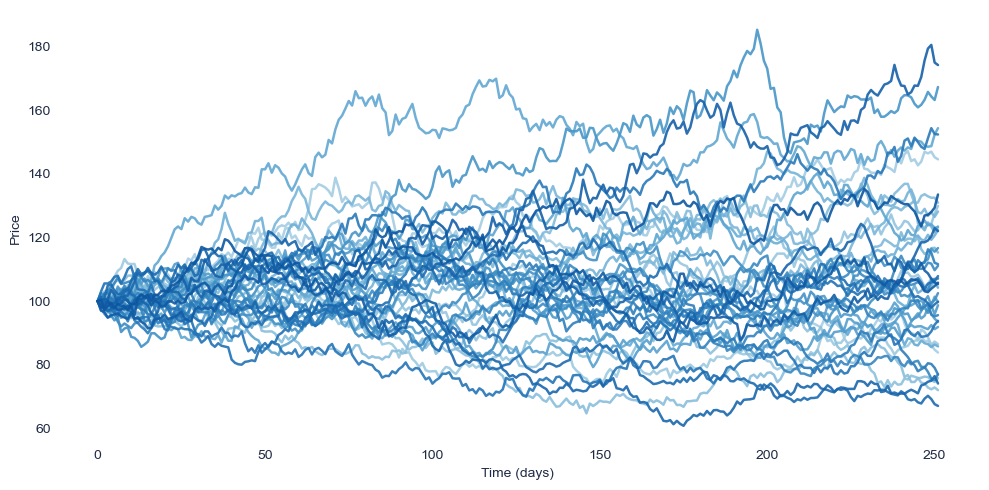

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- aesthetic settings ---
plt.style.use("seaborn-v0_8-white")
mpl.rcParams["figure.figsize"] = (10, 5)
mpl.rcParams["axes.edgecolor"] = "#1f2a44"   # dark navy
mpl.rcParams["axes.labelcolor"] = "#1f2a44"
mpl.rcParams["xtick.color"] = "#1f2a44"
mpl.rcParams["ytick.color"] = "#1f2a44"

# Generate synthetic stock paths (Geometric Brownian Motion)
np.random.seed(42)
T = 1
steps = 252
N = 40                # number of stock paths
mu = 0.10
sigma = 0.25
dt = T / steps

paths = np.zeros((steps, N))
paths[0] = 100

for i in range(1, steps):
    noise = np.random.normal(0, 1, N)
    paths[i] = paths[i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*noise)

# --- Build a blue color gradient ---
blues = mpl.cm.Blues(np.linspace(0.35, 0.85, N))

# --- Plot ---
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(paths[:, i], color=blues[i], linewidth=1.8, alpha=0.9)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Price")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_frame_on(False)
plt.tight_layout()
plt.show()


/var/folders/yh/5_x_v8h90_q9yn_jzpz32llw0000gn/T/ipykernel_54167/3536330269.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10")(labels)  # 10 bright categorical colors


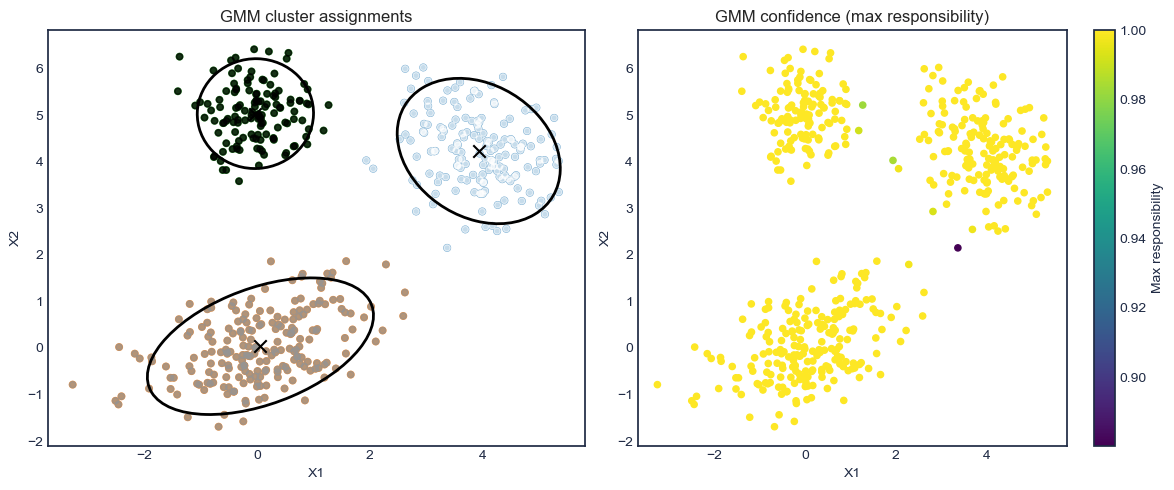

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# ------------------------
# 1. Generate synthetic data
# ------------------------
np.random.seed(42)

n_samples = 500

# Means of the true Gaussians
means = np.array([
    [0, 0],
    [4, 4],
    [0, 5]
])

# Covariances of the true Gaussians
covs = np.array([
    [[1.0, 0.3],
     [0.3, 0.5]],
    [[0.5, -0.2],
     [-0.2, 0.8]],
    [[0.3, 0.0],
     [0.0, 0.3]]
])

# Mixture weights
weights = np.array([0.4, 0.35, 0.25])

# Sample component labels
components = np.random.choice(len(means), size=n_samples, p=weights)

# Sample data from each component
X = np.zeros((n_samples, 2))
for k in range(len(means)):
    idx = components == k
    X[idx] = np.random.multivariate_normal(means[k], covs[k], size=idx.sum())

# ------------------------
# 2. Fit Gaussian Mixture Model
# ------------------------
gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    random_state=42
)
gmm.fit(X)

# Hard cluster assignments
labels = gmm.predict(X)

# Soft assignments (responsibilities)
probs = gmm.predict_proba(X)  # shape: (n_samples, n_components)

# ------------------------
# 3. Helper to plot Gaussian ellipses
# ------------------------
def plot_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    Plot an ellipse corresponding to the covariance matrix.
    n_std: number of standard deviations (default 2)
    """
    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    # Sort the eigenvalues and vectors
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Angle of the ellipse (in degrees)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height of the ellipse (2*std in each direction)
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=theta,
        fill=False,
        **kwargs
    )
    ax.add_patch(ellipse)

# ------------------------
# 4. Plot: GMM clustering + ellipses
# ------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

import matplotlib.cm as cm
colors = cm.get_cmap("tab10")(labels)  # 10 bright categorical colors
ax[0].scatter(X[:, 0], X[:, 1], c=colors, s=22, alpha=0.85)

# Left: true data colored by GMM cluster
scatter = ax[0].scatter(X[:, 0], X[:, 1], c=labels, s=20, alpha=0.7)
ax[0].set_title("GMM cluster assignments")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

# Plot learned Gaussians (2-std ellipses)
for k in range(gmm.n_components):
    plot_ellipse(
        gmm.means_[k],
        gmm.covariances_[k],
        ax[0],
        n_std=2,
        edgecolor="black",
        linewidth=2
    )
    ax[0].scatter(
        gmm.means_[k, 0],
        gmm.means_[k, 1],
        c="black",
        s=80,
        marker="x"
    )

# Right: color points by maximum responsibility (soft clustering intensity)
max_probs = probs.max(axis=1)
scatter2 = ax[1].scatter(
    X[:, 0], X[:, 1],
    c=max_probs,
    s=20,
    cmap="viridis"
)
ax[1].set_title("GMM confidence (max responsibility)")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")
fig.colorbar(scatter2, ax=ax[1], label="Max responsibility")

plt.tight_layout()
plt.show()
